#Set-up

In [68]:
import os
import shutil
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub

In [69]:
# ----- Helper Functions for Multi-Spectral Images -----
def open_tif(fn, chnls=None, cls=torch.Tensor):
    im = np.array(Image.open(fn)).astype('float32')
    return cls(im)

def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, 'red', 'green'),
            map_filename(red_filename, 'red', 'blue'),
            map_filename(red_filename, 'red', 'nir')]

def get_ground_truth(red_filename):
    return map_filename(red_filename, 'red', 'gt')

def open_ms_tif(files):
    ms_img = None
    for path in files:
        img = open_tif(path)
        if ms_img is None:
            ms_img = img[None]  # Add a channel axis.
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)
    return torch.Tensor(ms_img)  # Shape: [4, height, width]

In [70]:
# ----- Download the Dataset -----
dataset_path = kagglehub.dataset_download("sorour/38cloud-cloud-segmentation-in-satellite-images")
print("Dataset downloaded to:", dataset_path)

# ----- Save the Dataset Locally -----
# Define a local directory where the dataset will be saved.
local_save_dir = "local_dataset"
os.makedirs(local_save_dir, exist_ok=True)
# Copy all files from the downloaded dataset directory to the local_save_dir.
# The dirs_exist_ok=True parameter (Python 3.8+) allows merging directories.
shutil.copytree(dataset_path, local_save_dir, dirs_exist_ok=True)
print("Dataset saved locally at:", local_save_dir)

Dataset downloaded to: /root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4
Dataset saved locally at: local_dataset


In [146]:
# ----- Collate the Bands -----
# Use the training folder structure: "38-Cloud_training/train_red", "train_green", "train_blue", "train_nir", etc.
train_red_folder = os.path.join(local_save_dir, "38-Cloud_training", "train_red")

def is_all_zeros(fn):
    img = np.array(Image.open(fn)).astype('float32')
    return np.all(img == 0)

# Collect all red files and filter out those that are all zeros.
red_files = [os.path.join(train_red_folder, f)
             for f in os.listdir(train_red_folder) if f.endswith('.TIF')]
red_files = [f for f in red_files if not is_all_zeros(f)]
if not red_files:
    raise ValueError("No red band .tif files found in the 'train_red' folder.")

In [147]:
selected_red = red_files[424]
print("Using red band file:", selected_red)

# Get the corresponding band files (green, blue, nir)
band_files = get_filenames(selected_red)
print("Band files:", band_files)

# Open the multispectral image (tensor shape: [4, height, width])
ms_image = open_ms_tif(band_files)
ms_np = ms_image.numpy()

Using red band file: local_dataset/38-Cloud_training/train_red/red_patch_157_8_by_10_LC08_L1TP_045026_20160720_20170221_01_T1.TIF
Band files: ['local_dataset/38-Cloud_training/train_red/red_patch_157_8_by_10_LC08_L1TP_045026_20160720_20170221_01_T1.TIF', PosixPath('local_dataset/38-Cloud_training/train_green/green_patch_157_8_by_10_LC08_L1TP_045026_20160720_20170221_01_T1.TIF'), PosixPath('local_dataset/38-Cloud_training/train_blue/blue_patch_157_8_by_10_LC08_L1TP_045026_20160720_20170221_01_T1.TIF'), PosixPath('local_dataset/38-Cloud_training/train_nir/nir_patch_157_8_by_10_LC08_L1TP_045026_20160720_20170221_01_T1.TIF')]


#Data exploration

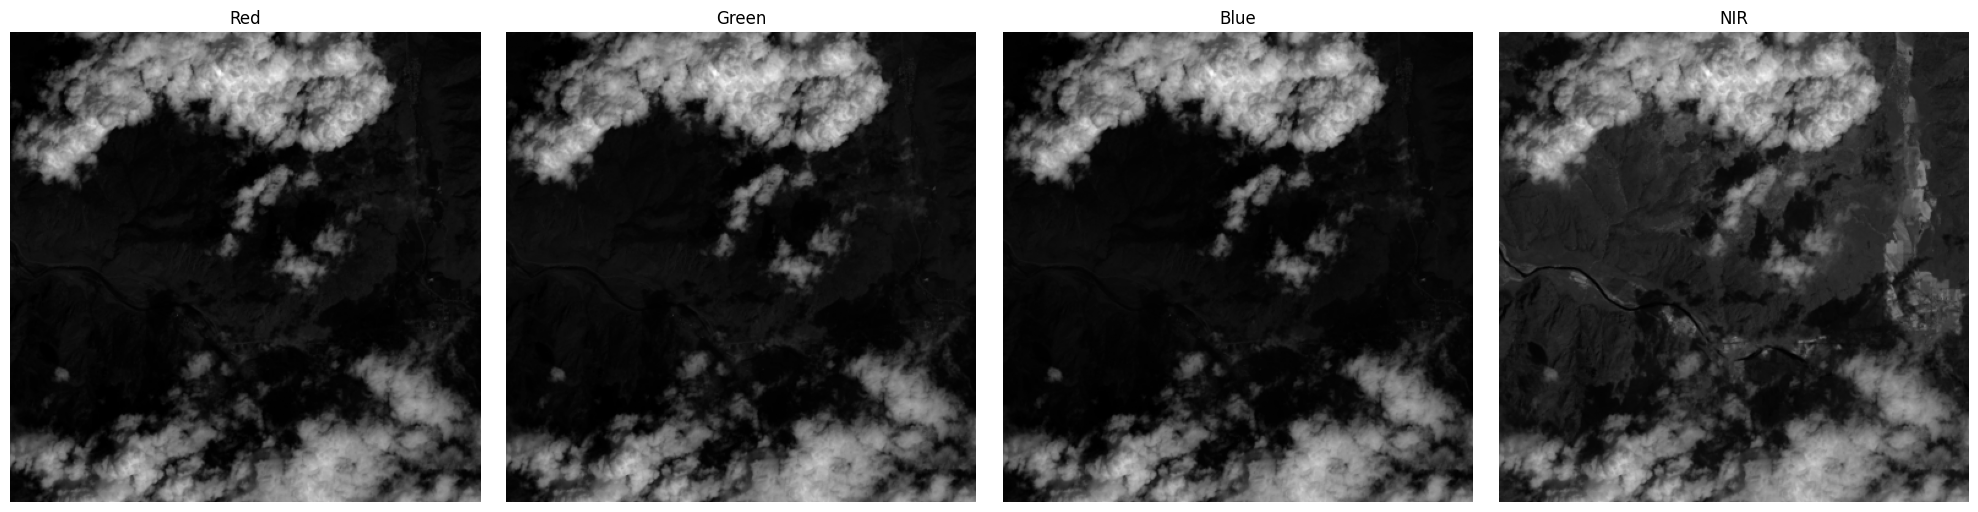

In [148]:
# ----- Display Each Band -----
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
band_names = ['Red', 'Green', 'Blue', 'NIR']

for i in range(4):
    axs[i].imshow(ms_np[i], cmap='gray')
    axs[i].set_title(band_names[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

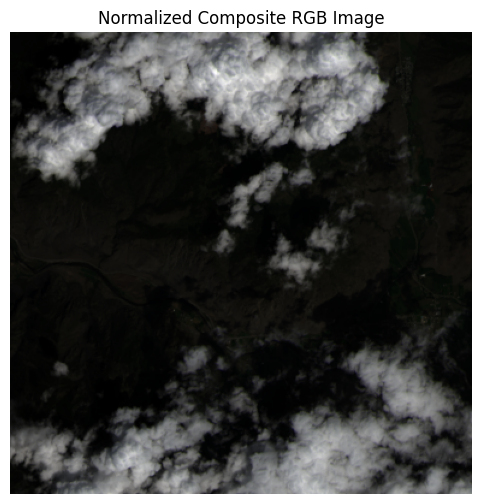

In [149]:
# ----- Optional: Create and Display a Composite RGB Image -----
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    norm = (band - band_min) / (band_max - band_min) * 255.0
    return norm.astype(np.uint8)

# Normalize red, green, and blue bands
red_norm   = normalize_band(ms_np[0])
green_norm = normalize_band(ms_np[1])
blue_norm  = normalize_band(ms_np[2])
nir_norm   = normalize_band(ms_np[3])

# Stack into an RGB composite
rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1)

# Display the normalized composite image
plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Normalized Composite RGB Image")
plt.axis('off')
plt.show()

#Otsu's Method

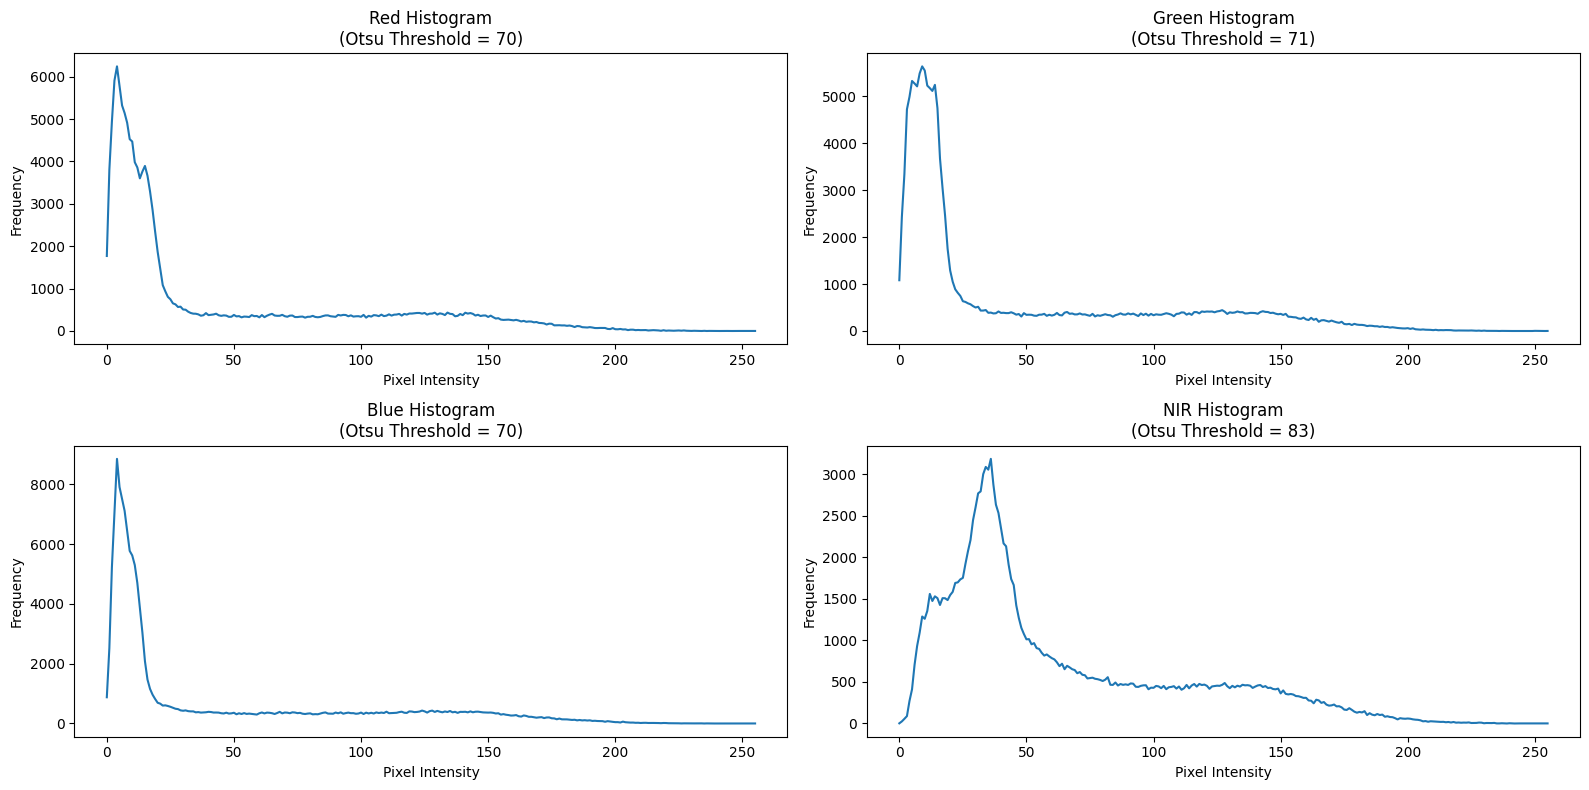

In [150]:
# ----- Compute Per-Band Histograms & Derive Thresholds (Otsu's Method) -----
bands_norm = [red_norm, green_norm, blue_norm, nir_norm]
band_names = ['Red', 'Green', 'Blue', 'NIR']
otsu_thresholds = []
band_masks = []

plt.figure(figsize=(16, 8))
for i, band in enumerate(bands_norm):
    # Compute histogram (for visualization)
    hist, bins = np.histogram(band.ravel(), bins=256, range=[0, 256])

    # Use Otsu's method to compute a threshold automatically.
    ret, mask = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_thresholds.append(ret)
    band_masks.append(mask)

    # Plot the histogram
    plt.subplot(2, 2, i+1)
    plt.plot(hist)
    plt.title(f"{band_names[i]} Histogram\n(Otsu Threshold = {ret:.0f})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

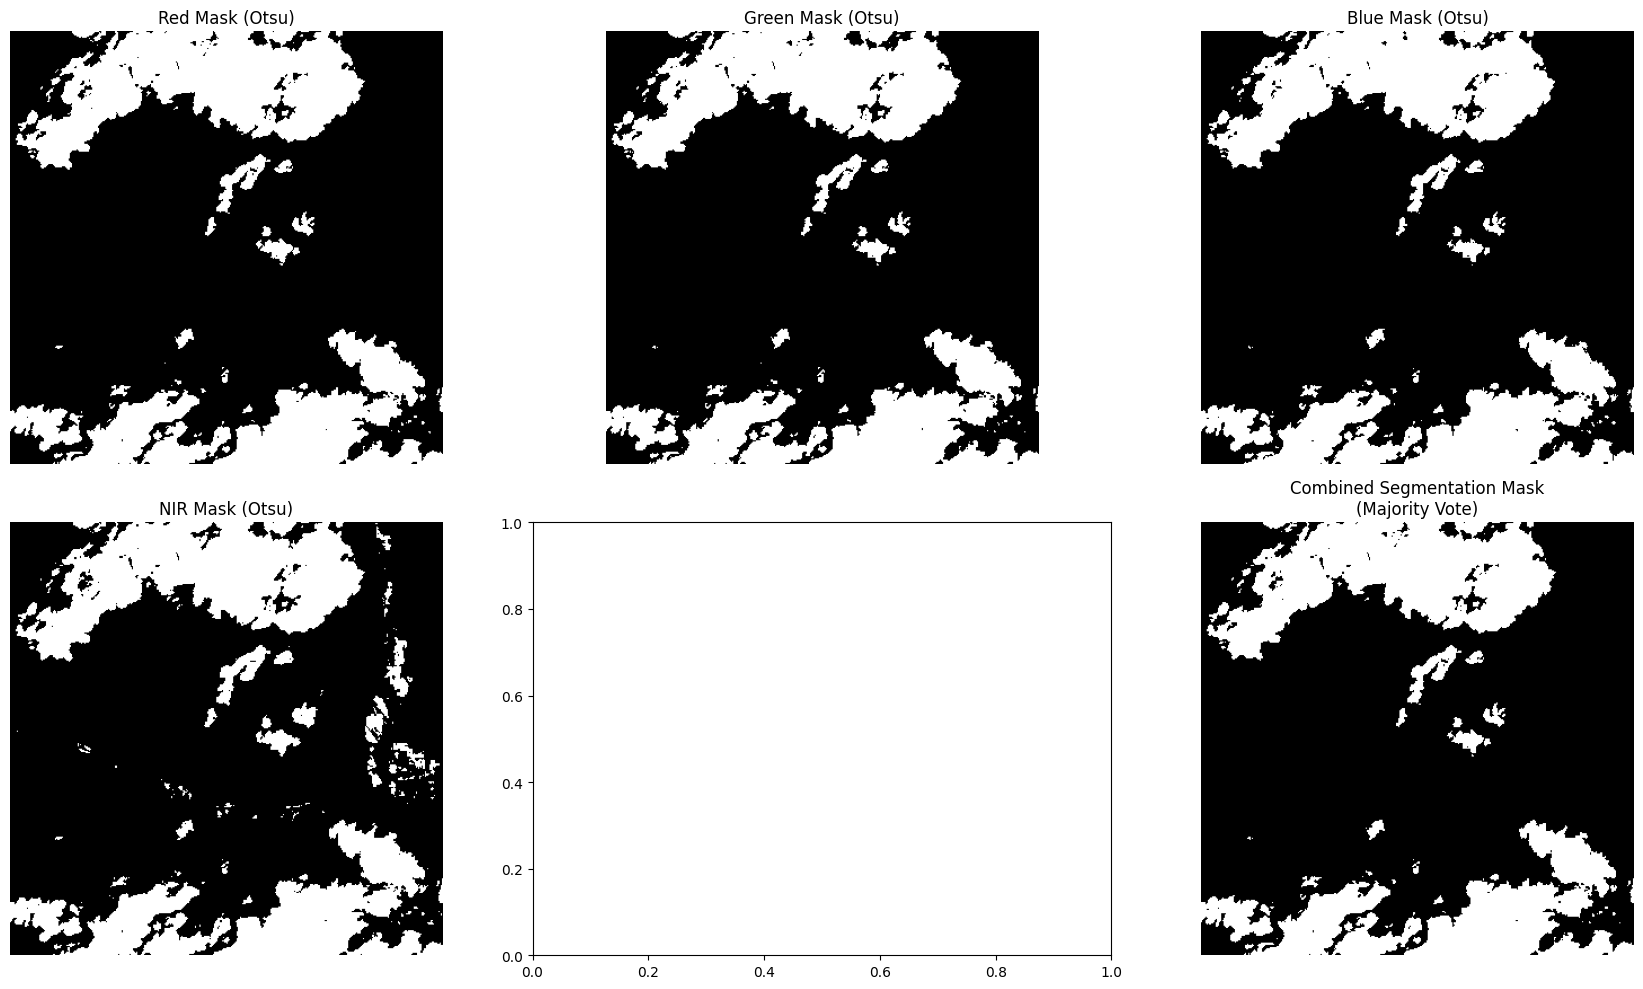

In [151]:
# ----- Combine Masks for Segmentation -----
# We'll use a majority vote rule: a pixel is classified as cloud if it is above its band-specific threshold
# in at least 3 out of 4 bands.
binary_masks = np.stack([mask // 255 for mask in band_masks], axis=0)  # convert masks to 0/1
vote_sum = np.sum(binary_masks, axis=0)
segmentation_mask = np.where(vote_sum >= 3, 255, 0).astype(np.uint8)

# ----- Display the Per-Band Masks and Combined Segmentation Mask -----
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for i, mask in enumerate(band_masks):
    axs[i//3, i%3].imshow(mask, cmap='gray')
    axs[i//3, i%3].set_title(f"{band_names[i]} Mask (Otsu)")
    axs[i//3, i%3].axis('off')
# Show the combined mask in the last subplot.
axs[1, 2].imshow(segmentation_mask, cmap='gray')
axs[1, 2].set_title("Combined Segmentation Mask\n(Majority Vote)")
axs[1, 2].axis('off')
plt.tight_layout()
plt.show()

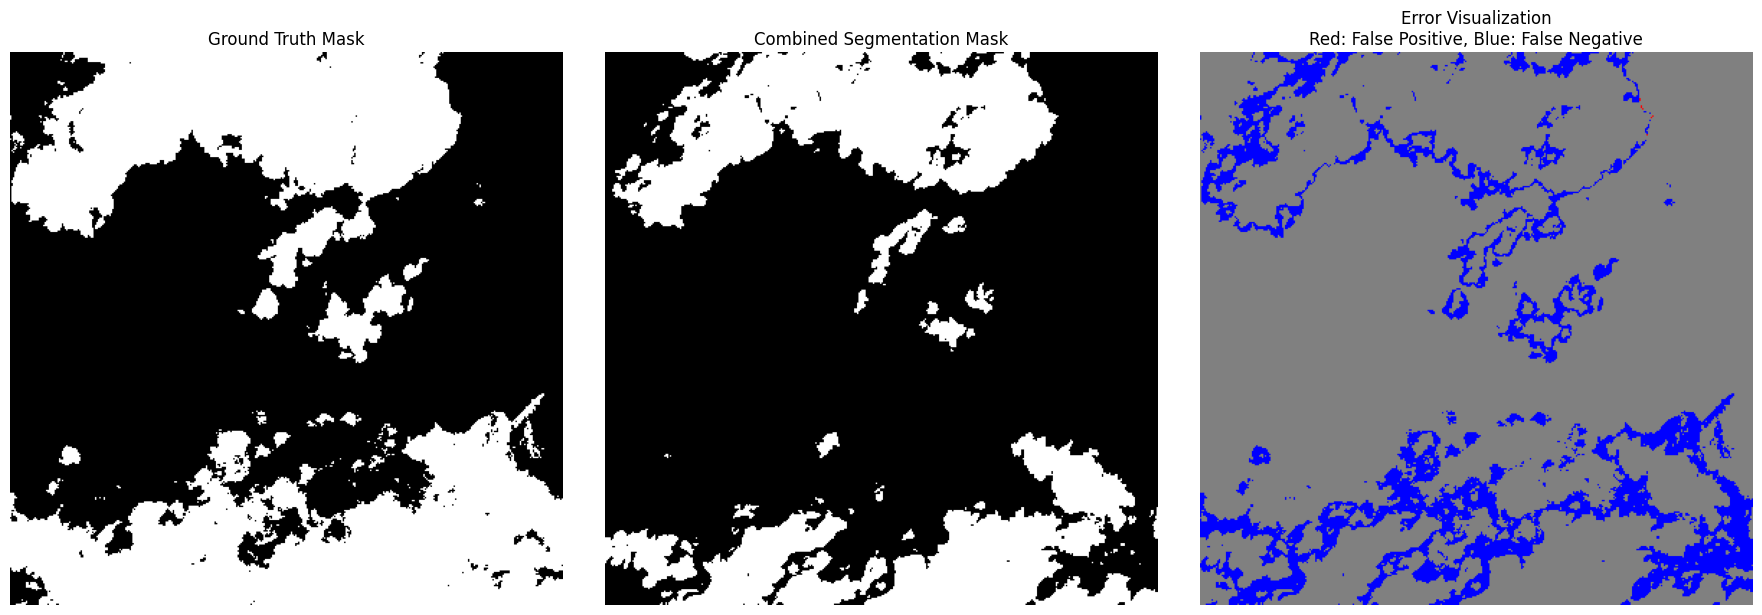

In [152]:
# ----- Display Ground Truth Mask with Colored Errors -----
# Get the ground truth file path and load the ground truth mask.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Compute error masks:
# False Positive (Type I error): predicted cloud but ground truth is non-cloud.
false_positive = np.logical_and(segmentation_mask == 255, ground_truth == 0)
# False Negative (Type II error): predicted non-cloud but ground truth indicates cloud.
false_negative = np.logical_and(segmentation_mask == 0, ground_truth == 255)

# Create an RGB image for the error visualization.
height, width = ground_truth.shape
# Use a neutral gray background for clarity.
error_vis = np.ones((height, width, 3), dtype=np.uint8) * 128

# Overlay errors:
# Mark false positives in red.
error_vis[false_positive] = [255, 0, 0]
# Mark false negatives in blue.
error_vis[false_negative] = [0, 0, 255]

# Display the ground truth, combined segmentation mask, and the colored error visualization.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth mask.
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')

# Combined segmentation mask.
axs[1].imshow(segmentation_mask, cmap='gray')
axs[1].set_title("Combined Segmentation Mask")
axs[1].axis('off')

# Error visualization.
axs[2].imshow(error_vis)
axs[2].set_title("Error Visualization\nRed: False Positive, Blue: False Negative")
axs[2].axis('off')

plt.tight_layout()
plt.show()

#Supervised methods

In [106]:
import random

In [107]:
# ----- Sampling Training Images -----
# Instead of iterating over all red_files, we sample a subset (e.g. 250 images).
sample_size = 250
if len(red_files) > sample_size:
    sampled_red_files = random.sample(red_files, sample_size)
else:
    sampled_red_files = red_files

In [108]:
# ----- Build Training Dataset for LDA and GNB using Sampled Images -----
X_list_nobias = []
y_list_nobias = []

for red_file in sampled_red_files:
    # Load multispectral bands.
    band_files = get_filenames(red_file)
    ms_image = open_ms_tif(band_files)  # shape: [4, H, W]
    ms_np = ms_image.numpy()

    # Normalize each band.
    red_norm   = normalize_band(ms_np[0])
    green_norm = normalize_band(ms_np[1])
    blue_norm  = normalize_band(ms_np[2])
    nir_norm   = normalize_band(ms_np[3])

    # Stack bands into a feature array (H x W x 4) and flatten to (num_pixels, 4).
    features = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
    H, W, _ = features.shape
    features_flat = features.reshape(-1, 4).astype(np.float32) / 255.0  # Scale to [0,1]

    # Load corresponding ground truth and convert to binary.
    gt_file = get_ground_truth(red_file)
    ground_truth = open_tif(gt_file).numpy().astype(np.uint8)
    ground_truth_bin = (ground_truth > 127).astype(np.float32).flatten()

    X_list_nobias.append(features_flat)
    y_list_nobias.append(ground_truth_bin)

X_full_nobias = np.concatenate(X_list_nobias, axis=0)
y_full_nobias = np.concatenate(y_list_nobias, axis=0)

##Linear Discriminant Analysis

In [109]:
# Separate training samples by class.
X0 = X_full_nobias[y_full_nobias == 0]
X1 = X_full_nobias[y_full_nobias == 1]

# Compute the means of each class.
mean0 = X0.mean(axis=0)
mean1 = X1.mean(axis=0)

# Compute within-class scatter matrices.
S0 = np.cov(X0, rowvar=False) * (X0.shape[0] - 1)
S1 = np.cov(X1, rowvar=False) * (X1.shape[0] - 1)
S_W = S0 + S1

# Compute the LDA weight vector.
w_lda = np.linalg.inv(S_W).dot(mean1 - mean0)

# Compute the intercept.
w0_lda = -0.5 * (mean0.dot(np.linalg.inv(S_W).dot(mean0)) - mean1.dot(np.linalg.inv(S_W).dot(mean1)))

# Compute class priors.
prior0 = X0.shape[0] / X_full_nobias.shape[0]
prior1 = X1.shape[0] / X_full_nobias.shape[0]

# Adjust the intercept.
w0_lda_adjusted = w0_lda + np.log(prior1 / prior0)

In [153]:
# ----- Apply LDA to a Selected Test Image -----
selected_red = red_files[424]
band_files = get_filenames(selected_red)
ms_image = open_ms_tif(band_files)
ms_np = ms_image.numpy()

# Normalize bands.
red_norm   = normalize_band(ms_np[0])
green_norm = normalize_band(ms_np[1])
blue_norm  = normalize_band(ms_np[2])
nir_norm   = normalize_band(ms_np[3])

# Prepare test features.
features_test = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
H, W, _ = features_test.shape
X_test_lda = features_test.reshape(-1, 4).astype(np.float32) / 255.0

# Compute LDA predictions.
y_scores_lda = X_test_lda.dot(w_lda) + w0_lda_adjusted
segmentation_lda = (y_scores_lda > 0).reshape(H, W).astype(np.uint8) * 255

# Compute error masks for LDA.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)
false_positive_lda = np.logical_and(segmentation_lda == 255, ground_truth == 0)
false_negative_lda = np.logical_and(segmentation_lda == 0, ground_truth == 255)

error_vis_lda = np.ones((H, W, 3), dtype=np.uint8) * 128
error_vis_lda[false_positive_lda] = [255, 0, 0]
error_vis_lda[false_negative_lda] = [0, 0, 255]

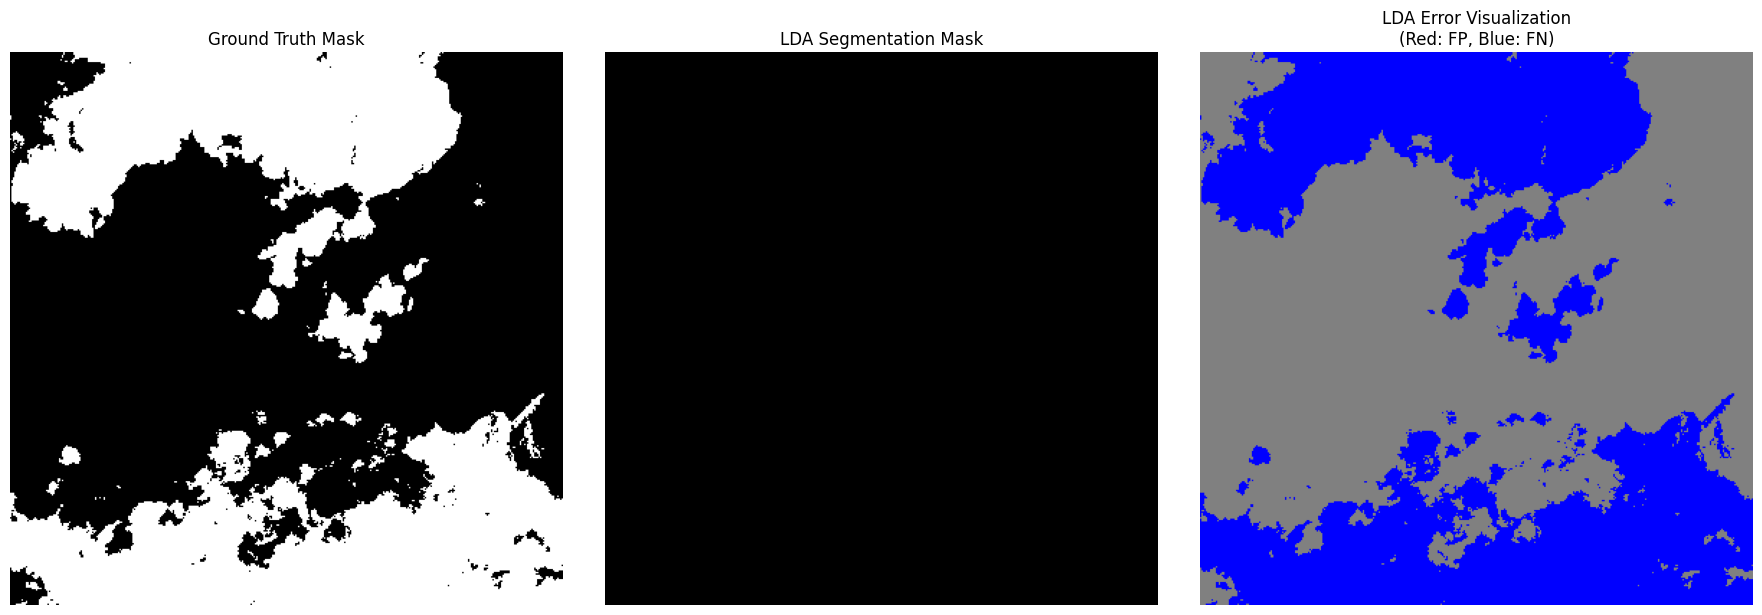

In [112]:
# ----- Display LDA Results -----
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')
axs[1].imshow(segmentation_lda, cmap='gray')
axs[1].set_title("LDA Segmentation Mask")
axs[1].axis('off')
axs[2].imshow(error_vis_lda)
axs[2].set_title("LDA Error Visualization\n(Red: FP, Blue: FN)")
axs[2].axis('off')
plt.tight_layout()
plt.show()

## Gaussian Naive Bayes

In [113]:
# Compute per-feature statistics for each class.
mean0_gnb = X0.mean(axis=0)
var0_gnb = X0.var(axis=0) + 1e-6  # Prevent division by zero.
mean1_gnb = X1.mean(axis=0)
var1_gnb = X1.var(axis=0) + 1e-6

# Class priors.
prior0 = X0.shape[0] / X_full_nobias.shape[0]
prior1 = X1.shape[0] / X_full_nobias.shape[0]

# Helper to compute log Gaussian likelihood.
def log_gaussian(x, mean, var):
    return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2 / var)


In [154]:
# ----- Apply GNB to the Same Test Image -----
X_test_gnb = X_test_lda  # Reuse the same test features.

# Compute log-likelihoods.
log_prob0 = np.log(prior0) + np.sum(log_gaussian(X_test_gnb, mean0_gnb, var0_gnb), axis=1)
log_prob1 = np.log(prior1) + np.sum(log_gaussian(X_test_gnb, mean1_gnb, var1_gnb), axis=1)

# Classify based on higher log-likelihood.
y_pred_gnb = (log_prob1 > log_prob0).astype(np.uint8)
segmentation_gnb = y_pred_gnb.reshape(H, W) * 255

# Compute error masks for GNB.
false_positive_gnb = np.logical_and(segmentation_gnb == 255, ground_truth == 0)
false_negative_gnb = np.logical_and(segmentation_gnb == 0, ground_truth == 255)

error_vis_gnb = np.ones((H, W, 3), dtype=np.uint8) * 128
error_vis_gnb[false_positive_gnb] = [255, 0, 0]
error_vis_gnb[false_negative_gnb] = [0, 0, 255]


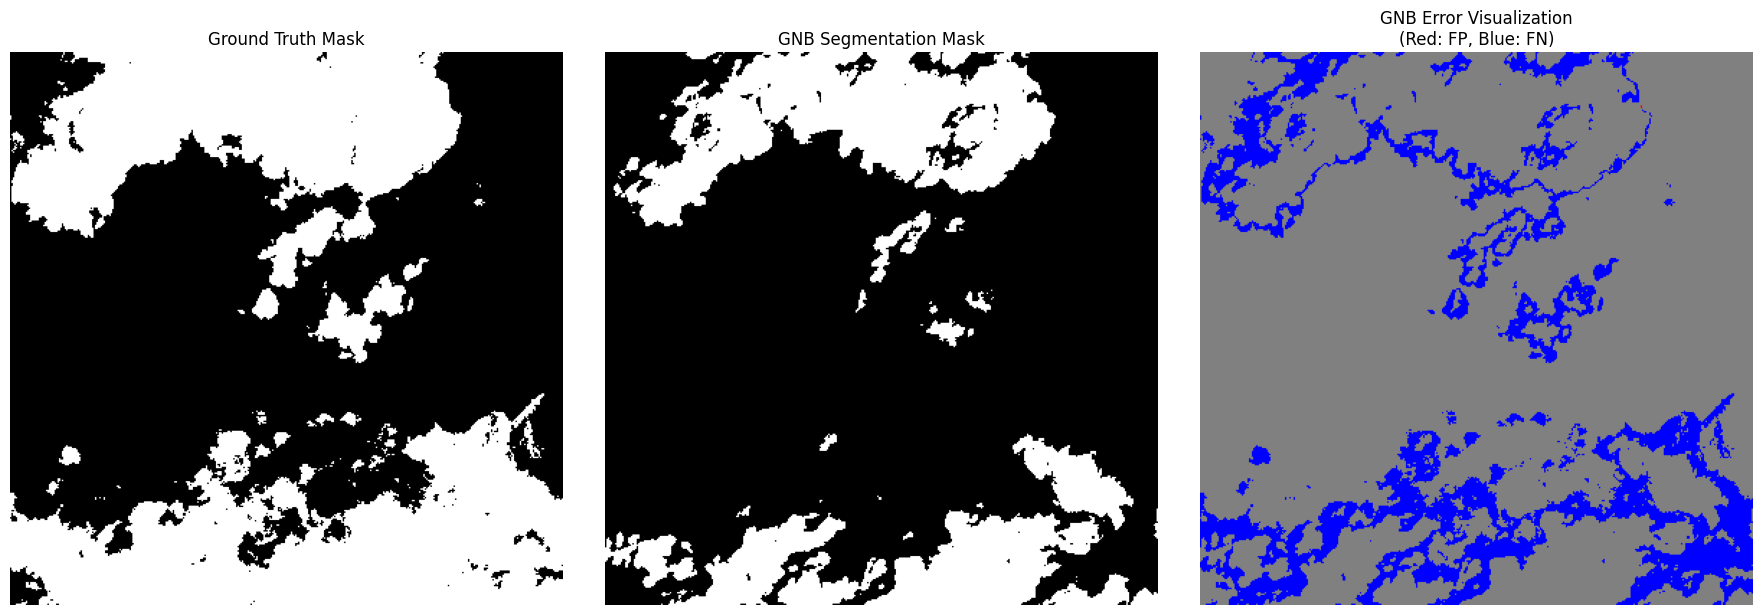

In [155]:
# ----- Display GNB Results -----
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')
axs[1].imshow(segmentation_gnb, cmap='gray')
axs[1].set_title("GNB Segmentation Mask")
axs[1].axis('off')
axs[2].imshow(error_vis_gnb)
axs[2].set_title("GNB Error Visualization\n(Red: FP, Blue: FN)")
axs[2].axis('off')
plt.tight_layout()
plt.show()

## Histogram-based Supervised Method

In [156]:
# Number of bins to use for the histograms (you can adjust this parameter).
nbins = 32
bins = np.linspace(0, 1, nbins+1)

# Initialize histograms for each of the 4 bands, for each class.
# histograms0 and histograms1 will be arrays of shape (4, nbins)
histograms0 = np.zeros((4, nbins))
histograms1 = np.zeros((4, nbins))

# Compute histograms for each band separately, for each class.
for i in range(4):
    # For non-cloud class (label 0)
    feature_vals0 = X_full_nobias[y_full_nobias == 0][:, i]
    counts0, _ = np.histogram(feature_vals0, bins=bins)
    histograms0[i, :] = counts0

    # For cloud class (label 1)
    feature_vals1 = X_full_nobias[y_full_nobias == 1][:, i]
    counts1, _ = np.histogram(feature_vals1, bins=bins)
    histograms1[i, :] = counts1

# Apply Laplace smoothing by adding 1 count to each bin.
histograms0 = histograms0 + 1
histograms1 = histograms1 + 1

# Convert counts to probabilities by dividing by the total counts (per band).
total0 = histograms0.sum(axis=1, keepdims=True)
prob_hist0 = histograms0 / total0

total1 = histograms1.sum(axis=1, keepdims=True)
prob_hist1 = histograms1 / total1

# Compute class priors from the training data.
prior0 = np.sum(y_full_nobias == 0) / y_full_nobias.shape[0]
prior1 = np.sum(y_full_nobias == 1) / y_full_nobias.shape[0]


In [157]:
# ----- Apply the Histogram-based Classifier on a Test Image -----
selected_red = red_files[424]  # Use the same test image as before.
band_files = get_filenames(selected_red)
ms_image = open_ms_tif(band_files)
ms_np = ms_image.numpy()

# Normalize the bands.
red_norm   = normalize_band(ms_np[0])
green_norm = normalize_band(ms_np[1])
blue_norm  = normalize_band(ms_np[2])
nir_norm   = normalize_band(ms_np[3])

# Prepare test features.
features_test = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
H, W, _ = features_test.shape
X_test_hist = features_test.reshape(-1, 4).astype(np.float32) / 255.0

# For each pixel, compute the bin indices for each feature.
bin_indices_test = np.digitize(X_test_hist, bins) - 1
bin_indices_test = np.clip(bin_indices_test, 0, nbins-1)

# Initialize log-likelihoods for each class.
log_prob0_test = np.zeros(X_test_hist.shape[0])
log_prob1_test = np.zeros(X_test_hist.shape[0])

# Sum the log probabilities over all four bands.
for i in range(4):
    log_prob0_test += np.log(prob_hist0[i, bin_indices_test[:, i]])
    log_prob1_test += np.log(prob_hist1[i, bin_indices_test[:, i]])

# Incorporate log class priors.
log_prob0_test += np.log(prior0)
log_prob1_test += np.log(prior1)

# Predict each pixel as cloud (1) if log_prob1 > log_prob0.
y_pred_hist = (log_prob1_test > log_prob0_test).astype(np.uint8)
segmentation_hist = y_pred_hist.reshape(H, W) * 255

In [158]:
# ----- Compute Error Visualization -----
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

false_positive_hist = np.logical_and(segmentation_hist == 255, ground_truth == 0)
false_negative_hist = np.logical_and(segmentation_hist == 0, ground_truth == 255)

error_vis_hist = np.ones((H, W, 3), dtype=np.uint8) * 128
error_vis_hist[false_positive_hist] = [255, 0, 0]  # Red: False Positives.
error_vis_hist[false_negative_hist] = [0, 0, 255]  # Blue: False Negatives.


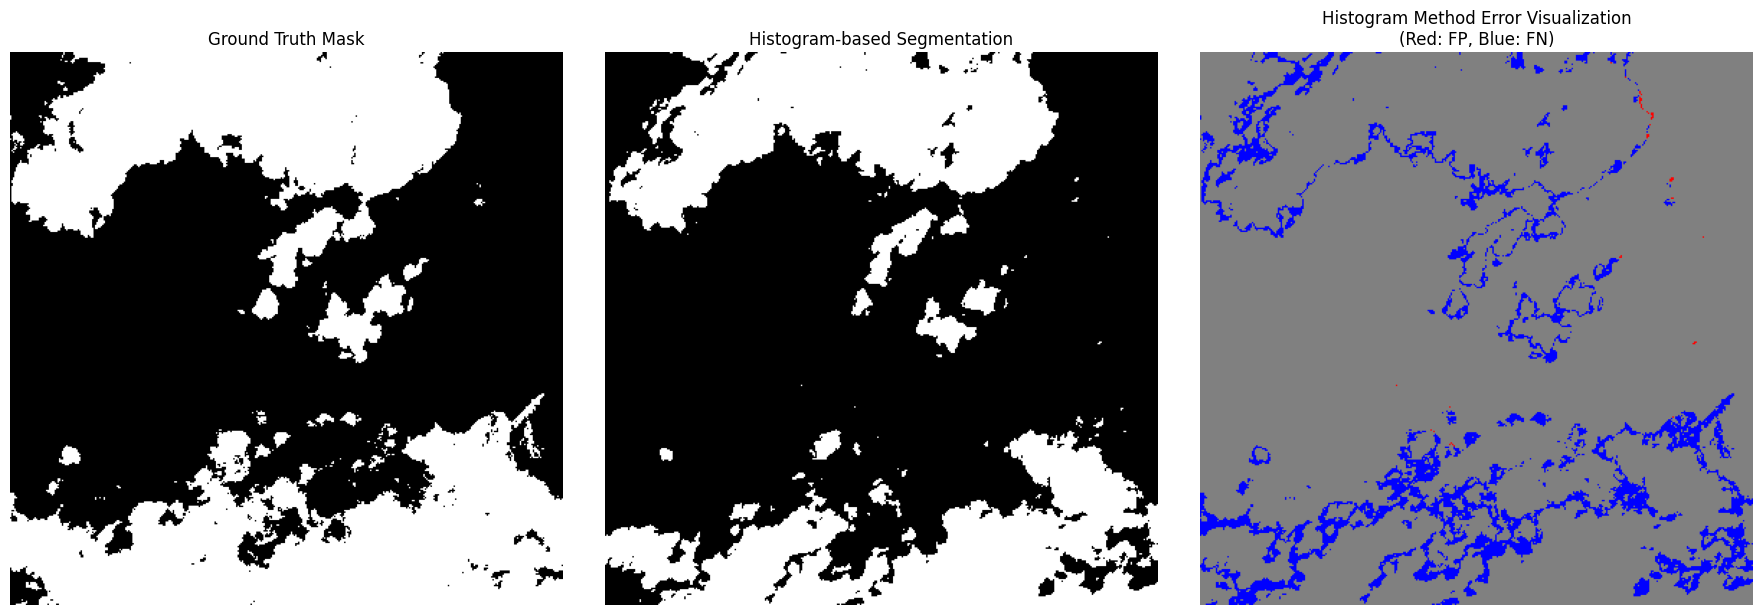

In [159]:
# ----- Display the Results -----
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')
axs[1].imshow(segmentation_hist, cmap='gray')
axs[1].set_title("Histogram-based Segmentation")
axs[1].axis('off')
axs[2].imshow(error_vis_hist)
axs[2].set_title("Histogram Method Error Visualization\n(Red: FP, Blue: FN)")
axs[2].axis('off')
plt.tight_layout()
plt.show()

#Metrics

In [123]:
import random
import cv2
import numpy as np

In [126]:
def compute_metrics(segmentation, ground_truth):
    """
    Compute segmentation evaluation metrics between a predicted mask and ground truth mask.

    Both segmentation and ground_truth are expected to be 2D arrays with values 0 or 255.

    Returns:
        A tuple: (precision, recall, F1 score, Jaccard index, accuracy)
    """
    # Convert masks to binary (0 and 1)
    seg_bin = (segmentation == 255).astype(np.uint8)
    gt_bin = (ground_truth == 255).astype(np.uint8)

    # Calculate true positives, false positives, false negatives, and true negatives
    tp = np.sum((seg_bin == 1) & (gt_bin == 1))
    fp = np.sum((seg_bin == 1) & (gt_bin == 0))
    fn = np.sum((seg_bin == 0) & (gt_bin == 1))
    tn = np.sum((seg_bin == 0) & (gt_bin == 0))

    # Calculate precision, recall, F1 score, Jaccard index, and accuracy.
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    jaccard   = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0

    return precision, recall, f1, jaccard, accuracy

In [134]:
# Sample 500 images from the training set.
sample_size = 500
sampled_files = random.sample(red_files, sample_size)

# Initialize accumulators for the metrics of each method.
metrics_sum_lda   = np.zeros(5)  # [precision, recall, f1, jaccard, accuracy]
metrics_sum_gnb   = np.zeros(5)
metrics_sum_hist  = np.zeros(5)
metrics_sum_otsu  = np.zeros(5)

count = 0

for red_file in sampled_files:
    # --- Load and preprocess the image ---
    band_files = get_filenames(red_file)
    ms_image = open_ms_tif(band_files)
    ms_np = ms_image.numpy()

    # Normalize each band (returns uint8 images).
    red_norm   = normalize_band(ms_np[0])
    green_norm = normalize_band(ms_np[1])
    blue_norm  = normalize_band(ms_np[2])
    nir_norm   = normalize_band(ms_np[3])

    # Ground truth.
    gt_file = get_ground_truth(red_file)
    ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

    # Build the feature array for supervised methods.
    features = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
    H, W, _ = features.shape
    # Scale features to [0,1] and flatten.
    X_test = features.reshape(-1, 4).astype(np.float32) / 255.0

    # --- Supervised Methods ---
    # 1. LDA
    # (Assuming w_lda and w0_lda are defined; adjust the intercept using class priors)
    w0_lda_adjusted = w0_lda + np.log(prior1 / prior0)
    y_scores_lda = X_test.dot(w_lda) + w0_lda_adjusted
    segmentation_lda = (y_scores_lda > 0).reshape(H, W).astype(np.uint8) * 255

    # 2. Gaussian Naive Bayes (GNB)
    log_prob0 = np.log(prior0) + np.sum(log_gaussian(X_test, mean0_gnb, var0_gnb), axis=1)
    log_prob1 = np.log(prior1) + np.sum(log_gaussian(X_test, mean1_gnb, var1_gnb), axis=1)
    y_pred_gnb = (log_prob1 > log_prob0).astype(np.uint8)
    segmentation_gnb = y_pred_gnb.reshape(H, W) * 255

    # 3. Histogram-based Classifier
    # Determine bin indices for each feature.
    bin_indices = np.digitize(X_test, bins) - 1
    bin_indices = np.clip(bin_indices, 0, nbins - 1)

    log_prob0_hist = np.zeros(X_test.shape[0])
    log_prob1_hist = np.zeros(X_test.shape[0])
    for i in range(4):
        log_prob0_hist += np.log(prob_hist0[i, bin_indices[:, i]])
        log_prob1_hist += np.log(prob_hist1[i, bin_indices[:, i]])
    log_prob0_hist += np.log(prior0)
    log_prob1_hist += np.log(prior1)
    y_pred_hist = (log_prob1_hist > log_prob0_hist).astype(np.uint8)
    segmentation_hist = y_pred_hist.reshape(H, W) * 255

    # --- Otsu's Method ---
    # Compute Otsu thresholds for each band and combine via majority vote.
    band_images = [red_norm, green_norm, blue_norm, nir_norm]
    binary_masks = []
    for band in band_images:
        ret, mask = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Convert to binary mask: 0 or 1.
        binary_masks.append(mask // 255)
    binary_masks = np.stack(binary_masks, axis=0)
    vote_sum = np.sum(binary_masks, axis=0)
    segmentation_otsu = np.where(vote_sum >= 3, 255, 0).astype(np.uint8)

    # --- Compute metrics for the current image ---
    metrics_lda  = np.array(compute_metrics(segmentation_lda, ground_truth))
    metrics_gnb  = np.array(compute_metrics(segmentation_gnb, ground_truth))
    metrics_hist = np.array(compute_metrics(segmentation_hist, ground_truth))
    metrics_otsu = np.array(compute_metrics(segmentation_otsu, ground_truth))

    metrics_sum_lda   += metrics_lda
    metrics_sum_gnb   += metrics_gnb
    metrics_sum_hist  += metrics_hist
    metrics_sum_otsu  += metrics_otsu

    count += 1

In [135]:
# Compute the average metrics.
avg_metrics_lda  = metrics_sum_lda / count
avg_metrics_gnb  = metrics_sum_gnb / count
avg_metrics_hist = metrics_sum_hist / count
avg_metrics_otsu = metrics_sum_otsu / count

# Print the averaged metrics.
print("Average Metrics over {} images:".format(count))
print("LDA:              Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics_lda))
print("GNB:              Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics_gnb))
print("Histogram-based:  Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics_hist))
print("Otsu's Method:    Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics_otsu))

Average Metrics over 500 images:
LDA:              Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Jaccard: 0.0000, Accuracy: 0.5366
GNB:              Precision: 0.7348, Recall: 0.6443, F1 Score: 0.6174, Jaccard: 0.5318, Accuracy: 0.7690
Histogram-based:  Precision: 0.6889, Recall: 0.7891, F1 Score: 0.6708, Jaccard: 0.6041, Accuracy: 0.7812
Otsu's Method:    Precision: 0.7201, Recall: 0.5769, F1 Score: 0.5631, Jaccard: 0.4578, Accuracy: 0.6955


#Ensembling

In [163]:
def ensemble_segmentation(segmentation_gnb, segmentation_hist, segmentation_otsu, threshold=2):
    """
    Compute ensemble segmentation using majority voting over four segmentation methods.

    Each segmentation mask is expected to be a 2D array with values 0 or 255.
    """
    # Convert each mask to binary (0 or 1)
    seg_gnb_bin  = (segmentation_gnb == 255).astype(np.uint8)
    seg_hist_bin = (segmentation_hist == 255).astype(np.uint8)
    seg_otsu_bin = (segmentation_otsu == 255).astype(np.uint8)

    # Sum votes from all methods.
    vote_sum = seg_gnb_bin + seg_hist_bin + seg_otsu_bin
    # Classify as cloud (255) if votes meet or exceed the threshold.
    ensemble_mask = np.where(vote_sum >= threshold, 255, 0).astype(np.uint8)

    return ensemble_mask

segmentation_ensemble = ensemble_segmentation(segmentation_gnb, segmentation_hist, segmentation_otsu)

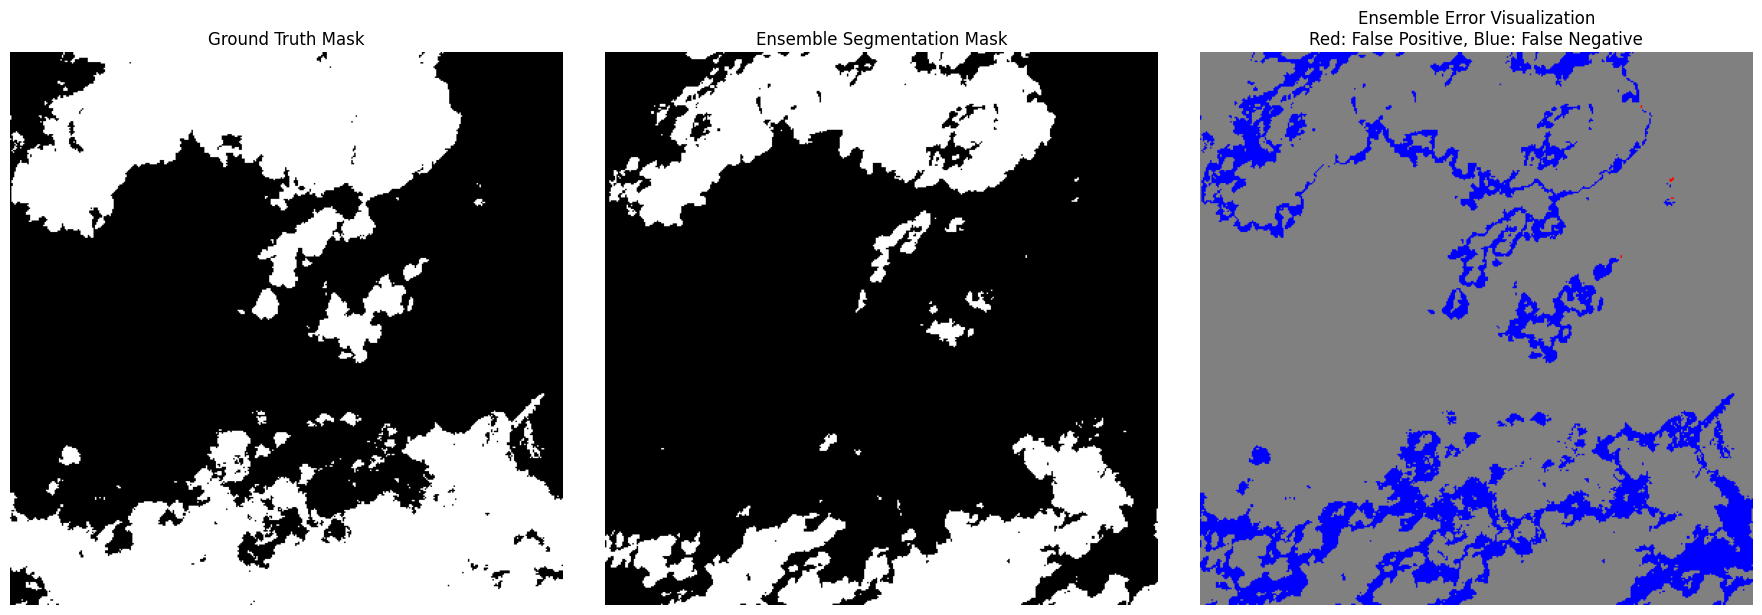

Ensemble Metrics (Precision, Recall, F1 Score, Jaccard, Accuracy): (0.9996692848284415, 0.6144217087878583, 0.7610704881400739, 0.6142968432461726, 0.8455471462673612)


In [164]:
# ----- Load Ground Truth -----
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# ----- Create Error Visualization (Using Red for False Positives, Blue for False Negatives) -----
false_positive = np.logical_and(segmentation_ensemble == 255, ground_truth == 0)
false_negative = np.logical_and(segmentation_ensemble == 0, ground_truth == 255)
error_vis = np.ones((H, W, 3), dtype=np.uint8) * 128  # neutral gray background
error_vis[false_positive] = [255, 0, 0]   # red for false positives
error_vis[false_negative] = [0, 0, 255]     # blue for false negatives

# ----- Visualization -----
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')

axs[1].imshow(segmentation_ensemble, cmap='gray')
axs[1].set_title("Ensemble Segmentation Mask")
axs[1].axis('off')

axs[2].imshow(error_vis)
axs[2].set_title("Ensemble Error Visualization\nRed: False Positive, Blue: False Negative")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Optionally, compute and print metrics for the ensemble segmentation.
ensemble_metrics = compute_metrics(segmentation_ensemble, ground_truth)
print("Ensemble Metrics (Precision, Recall, F1 Score, Jaccard, Accuracy):", ensemble_metrics)
